In [90]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [91]:
import numpy as np
import pandas as pd

In [92]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [93]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [94]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [95]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [96]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [97]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [98]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [99]:
#inspect measurement 
inspector = inspect(engine)
columns = inspector.get_columns("measurement")
for c in columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [100]:
#inspect station 
columns = inspector.get_columns("station")
for c in columns:
    print(c["name"], c["type"])


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


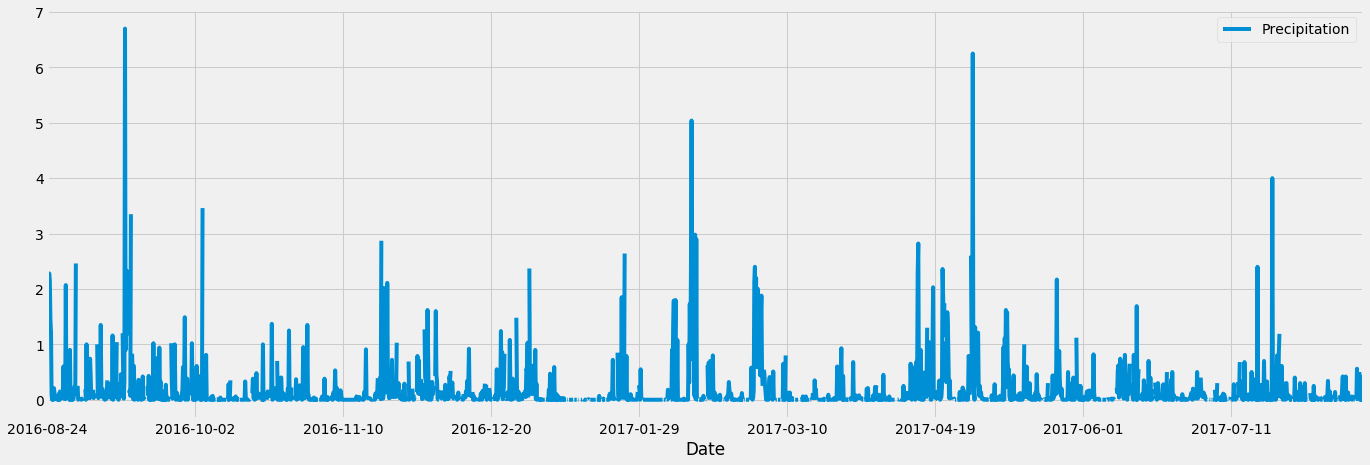

In [101]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date = last_date[0]
minus_365 = dt.datetime.strptime(last_date, "%Y-%m-%d") - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= minus_365).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip_data, columns=["Date", "Precipitation"])
precip_df.set_index("Date", inplace=True)

# Sort the dataframe by date
precip_df = precip_df.sort_values(by="Date",ascending=True)


# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(figsize = (21, 7))


In [102]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [103]:
# Design a query to show how many stations are available in this dataset?
stations_count_distinct = session.query(Measurement.station).distinct().count()
stations_count_distinct

9

In [104]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [105]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station = "USC00519281"
temperature_station = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
temperature_station


[(54.0, 85.0, 71.66378066378067)]

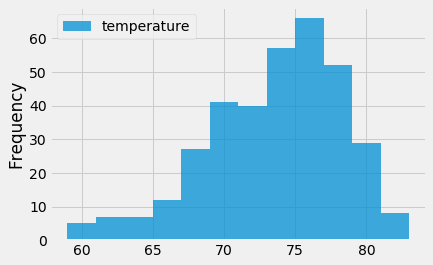

In [106]:
# Choose the station with the highest number of temperature observations 
station_max_temp_obs = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
station_max_temp_obs = station_max_temp_obs[0]

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tempe_obs_12m = session.query( Measurement.tobs).filter(Measurement.date >= minus_365).filter(Measurement.station == station_max_temp_obs).all()
temperature_observations_df = pd.DataFrame(tempe_obs_12m, columns=["temperature"])

temperature_observations_df.plot.hist(temperature_observations_df, bins = 12, alpha = 0.75)

In [107]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [108]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_trip_temperatures = calc_temps("2017-04-20", "2017-04-30")
my_trip_temperatures

[(58.0, 73.08695652173913, 81.0)]

Text(0, 0.5, 'Temp (F)')

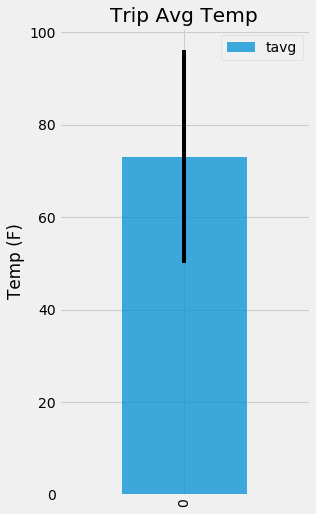

In [109]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

my_trip_temperatures_df = pd.DataFrame(my_trip_temperatures, columns=["tmin", "tavg", "tmax"])
my_trip_temperatures_df.plot.bar(y = "tavg", yerr=(my_trip_temperatures_df["tmax"] - my_trip_temperatures_df["tmin"]), title="Trip Avg Temp", figsize=(4,8), alpha = 0.75)
plt.ylabel("Temp (F)")

In [110]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation.

def rainfall_total(start_date, end_date):
    
    self = [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, Measurement.prcp]
    
    return session.query(*self).\
            filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

rainfall_total("2017-04-20", "2017-04-30")


[('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.35),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.33),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.05),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.05),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.0),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.0),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]